# Vapor Pressure

For an aerosol (ga phase + particle phase) in equilibrium with a liquid phase, the vapor pressure is the pressure of the vapor in equilibrium with the liquid phase. The vapor pressure is a measure of the tendency of particles to escape from the liquid phase and enter the gas phase. The vapor pressure dependence on temperature can take a few forms.

In this notebook, we will cover the vapor pressure strategies currently implemented in the `vapor_presure` module. 

Units are always in base SI units (kg/mol, kg/m^3, K, Pa).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Import the functions from the particula package
from particula.next import vapor_pressure

## Strategies for Vapor Pressure Calculations

In our framework, all strategies for calculating vapor pressure are encapsulated within classes that inherit from the `VaporPressureStrategy` abstract base class. This design ensures that each strategy conforms to a standardized interface, making them interchangeable and simplifying integration with other components of our system.

### Core Functions
We define two primary functions that form the backbone of our vapor pressure calculations:

- `calculate_partial_pressure`: This function computes the partial pressure of a gas given its concentration, molar mass, and temperature. It applies the ideal gas law to derive the partial pressure in Pascals (Pa).

- `calculate_concentration`: This function inversely calculates the concentration of a gas from its partial pressure, molar mass, and temperature, also using the ideal gas law.

These functions ensure that our calculations are consistent and can be reused across different strategies.

### Abstract Base Class
The `VaporPressureStrategy` class serves as an abstract base class that outlines the necessary methods for vapor pressure calculations:

- `partial_pressure`: Calculates the partial pressure of a gas based on its concentration, molar mass, and temperature.

- `concentration`: Calculates the concentration of a gas based on its partial pressure, temperature, and molar mass.

- `saturation_ratio`: Computes the ratio of the current vapor pressure to the saturation vapor pressure, which indicates how "saturated" the gas is with respect to a given temperature.

- `saturation_concentration`: Determines the maximum concentration of a gas at saturation at a given temperature.

- `pure_vapor_pressure`: This abstract method must be implemented by each subclass to calculate the pure (saturation) vapor pressure of a gas at specific temperatures.

By structuring our vapor pressure strategies around this abstract base class, we maintain high flexibility and robustness in our approach. Each subclass can implement specific behaviors for different gases or conditions, while relying on a common set of tools and interfaces provided by the base class.

# Example: Antoine Equation Vapor Pressure Strategy

The Antoine equation is a widely used empirical formula for estimating the vapor pressure of a substance over a range of temperatures. It takes the form:

$$
\log_{10}(P) = A - \frac{B}{T - C}
$$

where:
- $P$ is the vapor pressure in mmHg,
- $T$ is the temperature in Kelvin,
- $A$, $B$, and $C$ are substance-specific constants.
  - These constants are typically determined experimentally and can vary for different substances.
  - The Antoine equation is often used for organic compounds and provides a good approximation of vapor pressure behavior, over a limited temperature range.

We will implement this for the following substances, using constants from [link](https://onlinelibrary.wiley.com/doi/pdf/10.1002/9781118135341.app1):

- n-Butanol: "Formula": "C4H10O", "A": 7.838, "B": 1558.190, "C": 196.881

- Styrene: "Formula": "C8H8", "A": 6.92409, "B": 1420, "C": 226

- Water: "Formula": "H2O", "A": 7.94917, "B": 1657.462, "C": 227.02

In [2]:
# Initialize a specific strategy for calculating butanol's vapor pressure using Antoine's equation.
# We set the coefficients 'a', 'b', and 'c' which are specific to butanol.
butanol_antione = vapor_pressure.AntoineVaporPressureStrategy(
    a=7.838, b=1558.19, c=196.881)

# Initialize a strategy for styrene using a factory method.
# A factory method is a way to create objects without specifying the exact class of object that will be created.
# We pass 'antoine' as the strategy name and the coefficients as a dictionary.
styrene_coefficients = {'a': 6.924, 'b': 1420, 'c': 226}
styrene_antione = vapor_pressure.vapor_pressure_factory(
    strategy='antoine', **styrene_coefficients)

# Similar to styrene, initialize a strategy for water using the factory method.
# note the strategy name is case-insensitive.
water_coefficients = {'a': 7.949017, 'b': 1657.462, 'c': 227.02}
water_antione = vapor_pressure.vapor_pressure_factory(
    strategy='Antoine', **water_coefficients)

# Calculate and print the vapor pressures at 300 Kelvin for each substance using the initialized strategies.
# The function 'pure_vapor_pressure' is used here, which calculates the
# vapor pressure based on the provided temperature.
print(f'Butanol Antoine vapor pressure at 300 K: {butanol_antione.pure_vapor_pressure(300)} Pa')
print(f'Styrene Antoine vapor pressure at 300 K: {styrene_antione.pure_vapor_pressure(300)} Pa')
print(f'Water Antoine vapor pressure at 300 K: {water_antione.pure_vapor_pressure(300)} Pa')

Butanol Antoine vapor pressure at 300 K: 7.117073414020618e-06 Pa
Styrene Antoine vapor pressure at 300 K: 7.239567651587212e-11 Pa
Water Antoine vapor pressure at 300 K: 2.305354272293551e-13 Pa


## Temperature Variation

With the vapor pressure strategy implemented, we can now explore how the vapor pressure of these substances varies with temperature. We will plot the vapor pressure curves for n-Butanol, Styrene, and Water over a range of temperatures to observe their behavior.

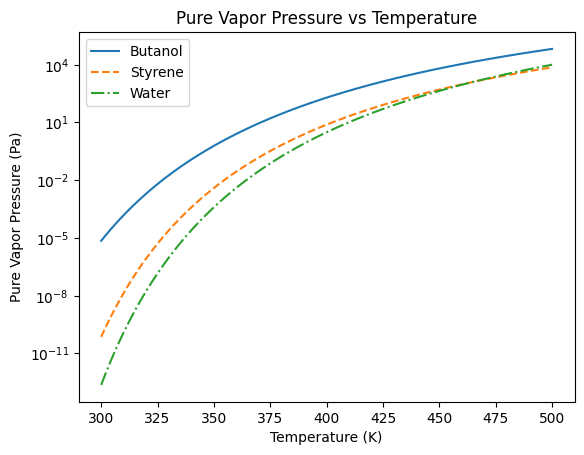

In [3]:
# create a range of temperatures from 200 to 400 Kelvin
temperatures = np.linspace(300, 500, 100)

# Calculate the vapor pressures for each substance at the range of temperatures.
butanol_vapor_pressure = butanol_antione.pure_vapor_pressure(temperatures)
styrene_vapor_pressure = styrene_antione.pure_vapor_pressure(temperatures)
water_vapor_pressure = water_antione.pure_vapor_pressure(temperatures)

# Plot the vapor pressures for each substance.
fig, ax = plt.subplots()
ax.plot(temperatures, butanol_vapor_pressure, label='Butanol')
ax.plot(temperatures, styrene_vapor_pressure, label='Styrene', linestyle='--')
ax.plot(temperatures, water_vapor_pressure, label='Water', linestyle='-.')
ax.set_yscale('log')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Pure Vapor Pressure (Pa)')
ax.set_title('Pure Vapor Pressure vs Temperature')
ax.legend()
plt.show()

## Saturation Concentration

We will also calculate the concentration of these substances at different temperatures. The saturation concentration represents the maximum amount of a substance that can be in a gas at a given temperature. By examining how the saturation concentration changes with temperature, we can gain insights into the solubility and volatility of these substances.

$$
C = \frac{P_{pure}M}{RT}
$$

where:
- $C$ is the concentration in kg/m^3,
- $P_{pure}$ is the pure vapor pressure in Pa, (also known as $P_{sat}$, or $P_{0}$),
- $M$ is the molar mass in kg/mol,
- $R$ is the ideal gas constant (8.314 J/(mol K)),
- $T$ is the temperature in Kelvin.


In the case of water, the saturation ratio can be used to determine the relative humidity of the air, as it is a key factor in weather and climate models. 

We can do this calculation from the directly from the vapor pressure strategy, as it is a common in the abstract base class. So even if we change how the vapor pressure is calculated, we can still use the same method to calculate the saturation concentration.

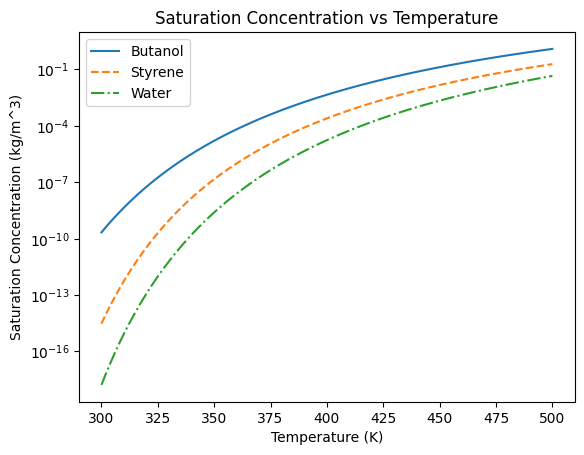

In [4]:
# Define the molar mass of each substance in kg/mol
butanol_molar_mass = 74.12e-3
styrene_molar_mass = 104.15e-3
water_molar_mass = 18.015e-3

# calculate the concentration pressure vs temperature
butanol_saturation_concentration = butanol_antione.saturation_concentration(
    molar_mass=butanol_molar_mass,
    temperature=temperatures)
styrene_saturation_concentration = styrene_antione.saturation_concentration(
    molar_mass=styrene_molar_mass,
    temperature=temperatures)
water_saturation_concentration = water_antione.saturation_concentration(
    molar_mass=water_molar_mass,
    temperature=temperatures)

# Plot the saturation concentrations for each substance.
fig, ax = plt.subplots()
ax.plot(temperatures, butanol_saturation_concentration, label='Butanol')
ax.plot(temperatures, styrene_saturation_concentration, label='Styrene', linestyle='--')
ax.plot(temperatures, water_saturation_concentration, label='Water', linestyle='-.')
ax.set_yscale('log')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Saturation Concentration (kg/m^3)')
ax.set_title('Saturation Concentration vs Temperature')
ax.legend()
plt.show()

# Partial Pressure

The partial pressure of a gas is the pressure that the gas would exert if it occupied the entire volume alone. It is a key concept in understanding gas mixtures and the behavior of gases in equilibrium. The partial pressure of a gas is proportional to its concentration and temperature, as described by the ideal gas law.

$$
P_{partial} = \frac{C R T}{M}
$$

where:
- $P_{partial}$ is the partial pressure in Pascals (Pa),
- $C$ is the concentration of the gas in kg/m^3,
- $R$ is the ideal gas constant (8.314 J/(mol K)),
- $T$ is the temperature in Kelvin,
- $M$ is the molar mass of the gas in kg/mol.

We can use the `calculate_partial_pressure` method from the vapor pressure strategy to calculate the partial pressure of a gas given its concentration, molar mass, and temperature. This calculation is essential for understanding the behavior of gas mixtures and the distribution of gases in a system.

We will use the partial pressure at 300 K and calculate how it changes with temperature for the three substances.


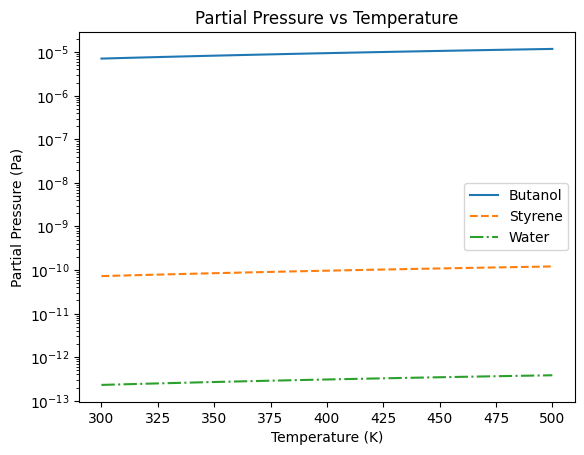

In [5]:
# saturation concentration at 300 K
butanol_300K_concentration = butanol_saturation_concentration[0]
styrene_300K_concentration = styrene_saturation_concentration[0]
water_300K_concentration = water_saturation_concentration[0]

# caculate the partial pressure of each substance at 300 K
butanol_partial_pressure = butanol_antione.partial_pressure(
    concentration=butanol_300K_concentration,
    molar_mass=butanol_molar_mass,
    temperature=temperatures)
styrene_partial_pressure = styrene_antione.partial_pressure(
    concentration=styrene_300K_concentration,
    molar_mass=styrene_molar_mass,
    temperature=temperatures)
water_partial_pressure = water_antione.partial_pressure(
    concentration=water_300K_concentration,
    molar_mass=water_molar_mass,
    temperature=temperatures)

# Plot the partial pressures for each substance.
fig, ax = plt.subplots()
ax.plot(temperatures, butanol_partial_pressure, label='Butanol')
ax.plot(temperatures, styrene_partial_pressure, label='Styrene', linestyle='--')
ax.plot(temperatures, water_partial_pressure, label='Water', linestyle='-.')
ax.set_yscale('log')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Partial Pressure (Pa)')
ax.set_title('Partial Pressure vs Temperature')
ax.legend()
plt.show()

## Saturation Ratio

The saturation ratio is the ratio of a gas's current vapor pressure to its saturation vapor pressure at a specific temperature. This ratio helps determine how "saturated" the gas is with respect to the substance it is in equilibrium with. A saturation ratio of 1 implies that the gas is at equilibrium with the liquid phase. Values less than 1 indicate that the gas is sub-saturated (less than equilibrium), and values greater than 1 indicate supersaturation (more than equilibrium).

$$
SR = \frac{P}{P_{sat}}
$$

where:
- $SR$ is the saturation ratio,
- $P$ is the partial pressure of the gas,
- $P_{sat}$ is the saturation vapor pressure of the gas at the given temperature.

To calculate the saturation ratio, we use the concentration of the gas and compare it to the saturation concentration. We calculate the partial pressure from the concentration and the saturation concentration, and then calculate the saturation ratio. 

We will start with the gas's initial concentration at 300K and calculate the saturation ratio at various temperatures while keeping the concentration constant.

This method simulates the behavior of a gas that is initially at equilibrium with its liquid phase at 300K. If the temperature changes but the concentration remains constant, the saturation ratio will begin at 1 and typically decrease as the temperature increases. This decrease reflects the gas moving from a state of equilibrium to a state of sub-saturation as it becomes less capable of remaining in the liquid phase at higher temperatures.

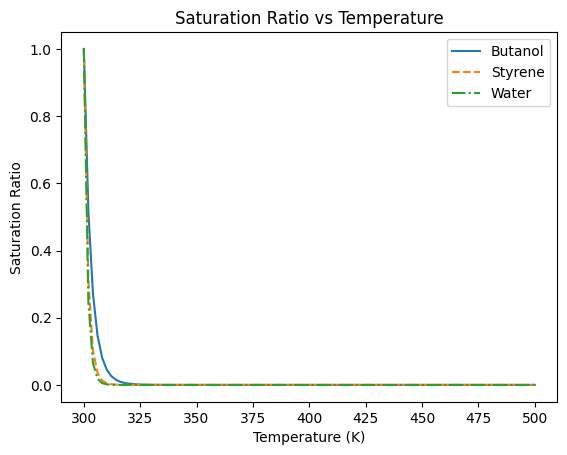

In [6]:
# caculate the saturation ratio
butanol_saturation_ratio = butanol_antione.saturation_ratio(
    concentration=butanol_300K_concentration,
    molar_mass=butanol_molar_mass,
    temperature=temperatures)
styrene_saturation_ratio = styrene_antione.saturation_ratio(
    concentration=styrene_300K_concentration,
    molar_mass=styrene_molar_mass,
    temperature=temperatures)
water_saturation_ratio = water_antione.saturation_ratio(
    concentration=water_300K_concentration,
    molar_mass=water_molar_mass,
    temperature=temperatures)

# Plot the saturation ratios for each substance.
fig, ax = plt.subplots()
ax.plot(temperatures, butanol_saturation_ratio, label='Butanol')
ax.plot(temperatures, styrene_saturation_ratio, label='Styrene', linestyle='--')
ax.plot(temperatures, water_saturation_ratio, label='Water', linestyle='-.')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Saturation Ratio')
ax.set_title('Saturation Ratio vs Temperature')
ax.legend()
plt.show()

## Other Strategies

In addition to the common methods shared across all vapor pressure strategies, we have several specialized strategies that can be employed to calculate vapor pressure based on different principles:

- **Constant**: This strategy applies a fixed value for the vapor pressure, regardless of external conditions.
- **Antoine**: Utilizes the Antoine equation to determine the vapor pressure of a substance, adjusting based on temperature changes.
- **Clausius_Clapeyron**: Employs the Clausius-Clapeyron equation to estimate changes in vapor pressure in response to temperature variations.
- **Water_Buck**: Specifically designed for water, this strategy uses the Buck equation to calculate vapor pressure accurately.

We will apply these different strategies to calculate the pure vapor pressure of water and observe how the values vary with temperature.

### Consistency Across Methods
Despite using different calculation strategies, the method calls remain consistent. This uniformity allows for straightforward substitutions between methods without altering the structure of the code.

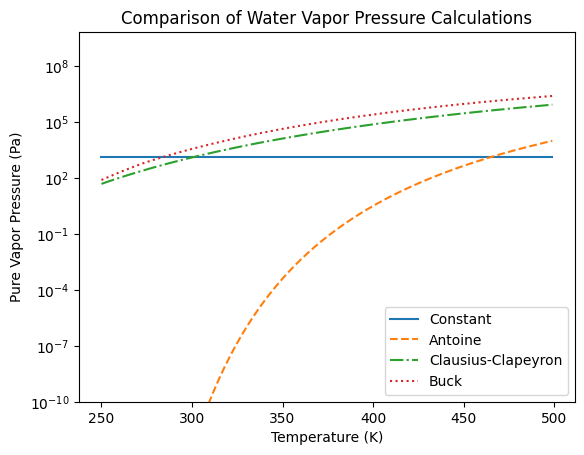

In [7]:
# Setting a constant vapor pressure at 300 K for water
water_pure_at_300K = 1234.56  # in Pascals (Pa)
water_constant_strategy = vapor_pressure.vapor_pressure_factory(
    strategy='constant', vapor_pressure=water_pure_at_300K)

# Setting parameters for the Clausius-Clapeyron equation for water
water_clausius_clapeyron_parameters = {
    'latent_heat': 40.7e3,  # specific latent heat J/mol
    'temperature_initial': 300,  # Initial temperature in Kelvin
    'pressure_initial': water_pure_at_300K  # Initial pressure in Pascals
}
water_clausius_clapeyron_strategy = vapor_pressure.vapor_pressure_factory(
    strategy='clausius_clapeyron', **water_clausius_clapeyron_parameters)

# Using the Water Buck strategy, no additional parameters needed
water_buck_strategy = vapor_pressure.vapor_pressure_factory(
    strategy='water_buck')

# Define a range of temperatures for which to calculate vapor pressures
temperatures = range(250, 500)  # From 280 K to 320 K

# Calculate the pure vapor pressure at different temperatures using
# various strategies
water_pure_constant = [water_constant_strategy.pure_vapor_pressure(
    temp) for temp in temperatures]
water_pure_antione = [water_antione.pure_vapor_pressure(
    temp) for temp in temperatures]
water_pure_clausius_clapeyron = [
    water_clausius_clapeyron_strategy.pure_vapor_pressure(temp) for temp in temperatures]
water_pure_buck = [water_buck_strategy.pure_vapor_pressure(
    temp) for temp in temperatures]

# Plotting the results using Matplotlib
fig, ax = plt.subplots()
ax.plot(temperatures, water_pure_constant, label='Constant', linestyle='-')
ax.plot(temperatures, water_pure_antione, label='Antoine', linestyle='--')
ax.plot(temperatures, water_pure_clausius_clapeyron,
        label='Clausius-Clapeyron', linestyle='-.')
ax.plot(temperatures, water_pure_buck, label='Buck', linestyle=':')
ax.set_yscale('log')
ax.set_ylim(bottom=1e-10)
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Pure Vapor Pressure (Pa)')
ax.set_title('Comparison of Water Vapor Pressure Calculations')
ax.legend(loc='lower right')
plt.show()

# Summary

In this notebook, we covered how the strategies for vapor pressure calculations are implemented in our system. By using an abstract base class and common core functions, we ensure that each strategy adheres to a standardized interface and can be easily integrated into our framework. We explored the Antoine equation vapor pressure strategy for n-Butanol, Styrene, and Water, examining how their vapor pressures and saturation concentrations change with temperature. We calculated the partial pressure, saturation ratio, and saturation concentration for these substances, providing insights into their behavior in gas-phase systems. Finally, we demonstrated the consistency and flexibility of our approach by applying different vapor pressure strategies to calculate the vapor pressure of water and observing how the values vary with temperature.

This modular and extensible design allows us to incorporate various vapor pressure calculation methods while maintaining a consistent interface and ensuring robustness and flexibility in our system.

# Help

Below is the help for each of the classes and methods used in this notebook.

In [8]:
help(vapor_pressure.calculate_concentration)

Help on function calculate_concentration in module particula.next.vapor_pressure:

calculate_concentration(partial_pressure: Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]], molar_mass: Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]], temperature: Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]]) -> Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]]
    Calculate the concentration of a gas from its partial pressure, molar mass,
    and temperature using the ideal gas law.
    
    Parameters:
    - pressure (float or NDArray[np.float_]): Partial pressure of the gas
    in Pascals (Pa).
    - molar_mass (float or NDArray[np.float_]): Molar mass of the gas in kg/mol
    - temperature (float or NDArray[np.float_]): Temperature in Kelvin.
    
    Returns:
    - concentration (float or NDArray[np.float_]): Concentration of the gas
    in kg/m^3.



In [9]:
help(vapor_pressure.calculate_partial_pressure)

Help on function calculate_partial_pressure in module particula.next.vapor_pressure:

calculate_partial_pressure(concentration: Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]], molar_mass: Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]], temperature: Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]]) -> Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]]
    Calculate the partial pressure of a gas from its concentration, molar mass,
    and temperature.
    
    Parameters:
    - concentration (float): Concentration of the gas in kg/m^3.
    - molar_mass (float): Molar mass of the gas in kg/mol.
    - temperature (float): Temperature in Kelvin.
    
    Returns:
    - float: Partial pressure of the gas in Pascals (Pa).



In [10]:
help(vapor_pressure.VaporPressureStrategy)

Help on class VaporPressureStrategy in module particula.next.vapor_pressure:

class VaporPressureStrategy(abc.ABC)
 |  Abstract class for vapor pressure calculations. The methods
 |  defined here must be implemented by subclasses below.
 |  
 |  Method resolution order:
 |      VaporPressureStrategy
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  concentration(self, partial_pressure: Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]], molar_mass: Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]], temperature: Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]]) -> Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]]
 |      Calculate the concentration of the gas at a given pressure and
 |      temperature.
 |      
 |      Args:
 |      ----
 |      - partial_pressure (float or NDArray[np.float_]): Pressure in Pascals.
 |      - molar_mass (float or NDArray[np.float_]): Molar mass of the gas in
 |      kg/mol.
 |    

In [11]:
help(vapor_pressure.vapor_pressure_factory)

Help on function vapor_pressure_factory in module particula.next.vapor_pressure:

vapor_pressure_factory(strategy: str, **kwargs) -> particula.next.vapor_pressure.VaporPressureStrategy
    Factory method to create a concrete VaporPressureStrategy object.
    
    Args:
    ----
    - strategy (str): The strategy to use for vapor pressure calculations.
    options: "constant", "antoine", "clausius_clapeyron", "water_buck".
    - **kwargs: Additional keyword arguments required for the strategy.
    
    Returns:
    -------
    - vapor_pressure_strategy (VaporPressureStrategy): A concrete
    implementation of the VaporPressureStrategy.



In [12]:
help(vapor_pressure.ConstantVaporPressureStrategy)

Help on class ConstantVaporPressureStrategy in module particula.next.vapor_pressure:

class ConstantVaporPressureStrategy(VaporPressureStrategy)
 |  ConstantVaporPressureStrategy(vapor_pressure: Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]])
 |  
 |  Concrete implementation of the VaporPressureStrategy using a constant
 |  vapor pressure value.
 |  
 |  Method resolution order:
 |      ConstantVaporPressureStrategy
 |      VaporPressureStrategy
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, vapor_pressure: Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]])
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  pure_vapor_pressure(self, temperature: Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]]) -> Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]]
 |      Return the constant vapor pressure value.
 |      
 |      Args:
 |      ----
 |      - temperature (float or 

In [13]:
help(vapor_pressure.AntoineVaporPressureStrategy)

Help on class AntoineVaporPressureStrategy in module particula.next.vapor_pressure:

class AntoineVaporPressureStrategy(VaporPressureStrategy)
 |  AntoineVaporPressureStrategy(a: Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]] = 0.0, b: Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]] = 0.0, c: Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]] = 0.0)
 |  
 |  Concrete implementation of the VaporPressureStrategy using the
 |  Antoine equation for vapor pressure calculations.
 |  
 |  Method resolution order:
 |      AntoineVaporPressureStrategy
 |      VaporPressureStrategy
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, a: Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]] = 0.0, b: Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]] = 0.0, c: Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]] = 0.0)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  


In [14]:
help(vapor_pressure.ClausiusClapeyronStrategy)

Help on class ClausiusClapeyronStrategy in module particula.next.vapor_pressure:

class ClausiusClapeyronStrategy(VaporPressureStrategy)
 |  ClausiusClapeyronStrategy(latent_heat: Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]], temperature_initial: Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]], pressure_initial: Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]])
 |  
 |  Concrete implementation of the VaporPressureStrategy using the
 |  Clausius-Clapeyron equation for vapor pressure calculations.
 |  
 |  Method resolution order:
 |      ClausiusClapeyronStrategy
 |      VaporPressureStrategy
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, latent_heat: Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]], temperature_initial: Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]], pressure_initial: Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]])
 |      Initializes the Cla

In [15]:
help(vapor_pressure.WaterBuckStrategy)

Help on class WaterBuckStrategy in module particula.next.vapor_pressure:

class WaterBuckStrategy(VaporPressureStrategy)
 |  Concrete implementation of the VaporPressureStrategy using the
 |  Buck equation for water vapor pressure calculations.
 |  
 |  Method resolution order:
 |      WaterBuckStrategy
 |      VaporPressureStrategy
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  pure_vapor_pressure(self, temperature: Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]]) -> Union[float, numpy.ndarray[Any, numpy.dtype[numpy.float64]]]
 |      Calculate the pure (saturation) vapor pressure using the Buck
 |      equation for water vapor.
 |      
 |      Args:
 |      ----
 |      - temperature (float or NDArray[np.float_]): Temperature in Kelvin.
 |      
 |      Returns:
 |      -------
 |      - vapor_pressure (float or NDArray[np.float_]): The vapor pressure in
 |      Pascals.
 |      
 |      References:
 |      ----------
 |      Buck, A. L.